In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [ ]:
num_samples = 100
sample_range = range(0, 100)

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.5, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [ ]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.19s/it]

Converged after 440 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:52<00:51, 17.28s/it]

Converged after 491 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.58s/it]

Converged after 376 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.81s/it]

Converged after 389 outer iterations



Processing Samples:   2%|▏         | 2/100 [03:05<2:29:32, 91.55s/it]

Converged after 280 outer iterations



Processing Samples:   3%|▎         | 3/100 [04:41<2:31:32, 93.74s/it]

Converged after 314 outer iterations



Processing Samples:   4%|▍         | 4/100 [06:16<2:30:33, 94.10s/it]

Converged after 337 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.29s/it]

Converged after 311 outer iterations



Processing Samples:   5%|▌         | 5/100 [07:55<2:32:07, 96.07s/it]

Converged after 362 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:49, 16.57s/it]

Converged after 474 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.50s/it]

Converged after 399 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.19s/it]

Converged after 325 outer iterations



Processing Samples:   6%|▌         | 6/100 [09:19<2:23:54, 91.86s/it]

Converged after 291 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.31s/it]

Converged after 410 outer iterations



Processing Samples:   7%|▋         | 7/100 [10:56<2:24:51, 93.46s/it]

Converged after 330 outer iterations



Processing Samples:   8%|▊         | 8/100 [12:35<2:26:18, 95.42s/it]

Converged after 421 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.57s/it]

Converged after 346 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.10s/it]

Converged after 413 outer iterations



Processing Samples:   9%|▉         | 9/100 [14:11<2:24:41, 95.40s/it]

Converged after 412 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.47s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.11s/it]

Converged after 475 outer iterations



Processing Samples:  10%|█         | 10/100 [15:51<2:25:22, 96.92s/it]

Converged after 425 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.96s/it]

Converged after 358 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.79s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.29s/it]

Converged after 459 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.60s/it]

Converged after 418 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.01s/it]

Converged after 416 outer iterations



Processing Samples:  13%|█▎        | 13/100 [20:38<2:18:03, 95.21s/it]

Converged after 255 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:35<01:09, 17.27s/it]

Converged after 495 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.07s/it]

Converged after 441 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.49s/it]

Converged after 440 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.29s/it]

Converged after 345 outer iterations



Processing Samples:  14%|█▍        | 14/100 [22:10<2:15:02, 94.22s/it]

Converged after 464 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.15s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.50s/it]

Converged after 428 outer iterations



Processing Samples:  15%|█▌        | 15/100 [23:41<2:12:09, 93.28s/it]

Converged after 323 outer iterations



Processing Samples:  16%|█▌        | 16/100 [25:13<2:10:19, 93.09s/it]

Converged after 266 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.67s/it]

Converged after 406 outer iterations



Processing Samples:  17%|█▋        | 17/100 [26:49<2:09:53, 93.90s/it]

Converged after 426 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.66s/it]

Converged after 481 outer iterations



Processing Samples:  18%|█▊        | 18/100 [28:27<2:09:57, 95.09s/it]

Converged after 299 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.41s/it]

Converged after 418 outer iterations



Processing Samples:  19%|█▉        | 19/100 [30:06<2:10:02, 96.32s/it]

Converged after 500 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.41s/it]

Converged after 410 outer iterations



Processing Samples:  20%|██        | 20/100 [31:40<2:07:18, 95.48s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:13, 13.95s/it]

Converged after 233 outer iterations



Processing Samples:  21%|██        | 21/100 [33:04<2:01:09, 92.02s/it]

Converged after 257 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.20s/it]

Converged after 430 outer iterations



Processing Samples:  22%|██▏       | 22/100 [34:35<1:59:27, 91.89s/it]

Converged after 284 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:31, 15.87s/it]

Converged after 430 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.12s/it]

Converged after 409 outer iterations



Processing Samples:  23%|██▎       | 23/100 [36:06<1:57:27, 91.53s/it]

Converged after 295 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.01s/it]

Converged after 463 outer iterations



Processing Samples:  24%|██▍       | 24/100 [37:43<1:57:52, 93.06s/it]

Converged after 485 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.74s/it]

Converged after 384 outer iterations



Processing Samples:  25%|██▌       | 25/100 [39:20<1:57:50, 94.27s/it]

Converged after 387 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.49s/it]

Converged after 472 outer iterations



Processing Samples:  26%|██▌       | 26/100 [40:51<1:55:16, 93.47s/it]

Converged after 283 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:16<01:22, 16.54s/it]

Converged after 466 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.26s/it]

Converged after 470 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.79s/it]

Converged after 451 outer iterations



Processing Samples:  27%|██▋       | 27/100 [42:23<1:53:04, 92.93s/it]

Converged after 281 outer iterations



Processing Samples:  28%|██▊       | 28/100 [44:05<1:54:41, 95.57s/it]

Converged after 412 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.11s/it]

Converged after 383 outer iterations



Processing Samples:  29%|██▉       | 29/100 [45:33<1:50:35, 93.46s/it]

Converged after 281 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:47, 15.99s/it]

Converged after 461 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.22s/it]

Converged after 419 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.32s/it]

Converged after 351 outer iterations



Processing Samples:  30%|███       | 30/100 [47:01<1:46:58, 91.69s/it]

Converged after 355 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.13s/it]

Converged after 398 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.62s/it]

Converged after 402 outer iterations



Processing Samples:  31%|███       | 31/100 [48:28<1:44:00, 90.45s/it]

Converged after 329 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:31<01:02, 15.54s/it]

Converged after 392 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:45<00:43, 14.63s/it]

Converged after 394 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.50s/it]

Converged after 425 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.80s/it]

Converged after 356 outer iterations



Processing Samples:  32%|███▏      | 32/100 [49:52<1:40:19, 88.52s/it]

Converged after 324 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.76s/it]

Converged after 451 outer iterations



Processing Samples:  33%|███▎      | 33/100 [51:27<1:40:51, 90.32s/it]

Converged after 433 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.18s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.74s/it]

Converged after 453 outer iterations



Processing Samples:  34%|███▍      | 34/100 [53:01<1:40:33, 91.42s/it]

Converged after 347 outer iterations



Processing Samples:  35%|███▌      | 35/100 [54:45<1:43:15, 95.32s/it]

Converged after 498 outer iterations



Processing Samples:  36%|███▌      | 36/100 [56:22<1:42:14, 95.85s/it]

Converged after 338 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:45<00:43, 14.55s/it]

Converged after 339 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:15, 15.10s/it]

Converged after 444 outer iterations



Processing Samples:  37%|███▋      | 37/100 [57:53<1:38:55, 94.21s/it]

Converged after 404 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:35, 17.84s/it]

Converged after 495 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.50s/it]

Converged after 412 outer iterations



Processing Samples:  38%|███▊      | 38/100 [59:31<1:38:29, 95.32s/it]

Converged after 372 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:50, 16.78s/it]

Converged after 492 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.01s/it]

Converged after 471 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:01:09<1:37:58, 96.36s/it]

Converged after 396 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.93s/it]

Converged after 340 outer iterations



Processing Samples:  40%|████      | 40/100 [1:02:42<1:35:08, 95.13s/it]

Converged after 412 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.41s/it]

Converged after 360 outer iterations



Processing Samples:  41%|████      | 41/100 [1:04:17<1:33:43, 95.31s/it]

Converged after 307 outer iterations



Processing Samples:  42%|████▏     | 42/100 [1:05:58<1:33:37, 96.85s/it]

Converged after 417 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.47s/it]

Converged after 382 outer iterations



Processing Samples:  43%|████▎     | 43/100 [1:07:31<1:30:54, 95.69s/it]

Converged after 333 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.40s/it]

Converged after 433 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.82s/it]

Converged after 438 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:09:08<1:29:48, 96.23s/it]

Converged after 456 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:19<01:36, 19.36s/it]

Converged after 474 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.11s/it]

Converged after 454 outer iterations
Converged after 321 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:10:37<1:26:09, 93.99s/it]

Converged after 231 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.40s/it]

Converged after 409 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.95s/it]

Converged after 450 outer iterations



Processing Samples:  46%|████▌     | 46/100 [1:12:13<1:25:02, 94.49s/it]

Converged after 398 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.57s/it]

Converged after 418 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:13:49<1:23:51, 94.93s/it]

Converged after 483 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.21s/it]

Converged after 476 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:15:31<1:24:14, 97.21s/it]

Converged after 372 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:15, 15.92s/it]

Converged after 410 outer iterations



Processing Samples:  49%|████▉     | 49/100 [1:17:07<1:22:19, 96.86s/it]

Converged after 341 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.29s/it]

Converged after 438 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:18:38<1:19:12, 95.06s/it]

Converged after 283 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.08s/it]

Converged after 415 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.90s/it]

Converged after 422 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.43s/it]

Converged after 259 outer iterations



Processing Samples:  51%|█████     | 51/100 [1:20:05<1:15:34, 92.55s/it]

Converged after 316 outer iterations



Processing Samples:  52%|█████▏    | 52/100 [1:21:49<1:16:51, 96.08s/it]

Converged after 446 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:47, 15.98s/it]

Converged after 469 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.75s/it]

Converged after 347 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:23:20<1:13:59, 94.46s/it]

Converged after 399 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.91s/it]

Converged after 465 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.42s/it]

Converged after 455 outer iterations



Processing Samples:  54%|█████▍    | 54/100 [1:24:59<1:13:24, 95.76s/it]

Converged after 439 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:48, 16.03s/it]

Converged after 467 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.27s/it]

Converged after 490 outer iterations



Processing Samples:  55%|█████▌    | 55/100 [1:26:30<1:10:55, 94.56s/it]

Converged after 258 outer iterations



Processing Samples:  56%|█████▌    | 56/100 [1:28:06<1:09:36, 94.92s/it]

Converged after 320 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.35s/it]

Converged after 489 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.91s/it]

Converged after 352 outer iterations



Processing Samples:  57%|█████▋    | 57/100 [1:29:38<1:07:21, 93.98s/it]

Converged after 407 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:52<00:53, 17.82s/it]

Converged after 482 outer iterations



Processing Samples:  59%|█████▉    | 59/100 [1:33:01<1:06:43, 97.65s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.87s/it]

Converged after 492 outer iterations



Processing Samples:  60%|██████    | 60/100 [1:34:38<1:04:58, 97.47s/it]

Converged after 331 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.73s/it]

Converged after 385 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.95s/it]

Converged after 395 outer iterations



Processing Samples:  61%|██████    | 61/100 [1:36:10<1:02:10, 95.64s/it]

Converged after 349 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.92s/it]

Converged after 357 outer iterations



Processing Samples:  62%|██████▏   | 62/100 [1:37:40<59:32, 94.01s/it]  

Converged after 344 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.62s/it]

Converged after 472 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.17s/it]

Converged after 467 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [1:39:14<57:56, 93.96s/it]

Converged after 286 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.63s/it]

Converged after 410 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.84s/it]

Converged after 489 outer iterations



Processing Samples:  64%|██████▍   | 64/100 [1:40:49<56:41, 94.49s/it]

Converged after 374 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.08s/it]

Converged after 432 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.84s/it]

Converged after 469 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [1:42:24<55:11, 94.61s/it]

Converged after 374 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.83s/it]

Converged after 461 outer iterations
Converged after 458 outer iterations



Processing Samples:  66%|██████▌   | 66/100 [1:43:57<53:22, 94.19s/it]

Converged after 414 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.57s/it]

Converged after 467 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.08s/it]

Converged after 446 outer iterations



Processing Samples:  67%|██████▋   | 67/100 [1:45:40<53:13, 96.78s/it]

Converged after 462 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.40s/it]

Converged after 486 outer iterations



Processing Samples:  68%|██████▊   | 68/100 [1:47:15<51:13, 96.05s/it]

Converged after 285 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.58s/it]

Converged after 425 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:13, 13.86s/it]

Converged after 328 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [1:48:41<48:03, 93.00s/it]

Converged after 258 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:50, 16.67s/it]

Converged after 475 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.90s/it]

Converged after 397 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.55s/it]

Converged after 411 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.73s/it]

Converged after 378 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.50s/it]

Converged after 426 outer iterations



Processing Samples:  71%|███████   | 71/100 [1:51:47<44:56, 92.97s/it]

Converged after 270 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:27, 13.93s/it]

Converged after 291 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.56s/it]

Converged after 475 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.28s/it]

Converged after 387 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.57s/it]

Converged after 386 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [1:54:51<41:23, 91.97s/it]

Converged after 303 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.10s/it]

Converged after 471 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.63s/it]

Converged after 449 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [1:58:11<39:57, 95.92s/it]

Converged after 326 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:46, 15.38s/it]

Converged after 409 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.58s/it]

Converged after 464 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.18s/it]

Converged after 308 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [1:59:32<36:31, 91.33s/it]

Converged after 220 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.05s/it]

Converged after 419 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:01:10<35:48, 93.41s/it]

Converged after 287 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.38s/it]

Converged after 497 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.02s/it]

Converged after 496 outer iterations



Processing Samples:  78%|███████▊  | 78/100 [2:02:47<34:39, 94.54s/it]

Converged after 300 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.13s/it]

Converged after 471 outer iterations



Processing Samples:  79%|███████▉  | 79/100 [2:04:25<33:22, 95.38s/it]

Converged after 326 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.28s/it]

Converged after 476 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:06:06<32:23, 97.15s/it]

Converged after 376 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.10s/it]

Converged after 489 outer iterations



Processing Samples:  81%|████████  | 81/100 [2:07:49<31:17, 98.79s/it]

Converged after 436 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.70s/it]

Converged after 383 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:09:23<29:16, 97.59s/it]

Converged after 342 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:48, 16.09s/it]

Converged after 470 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.08s/it]

Converged after 400 outer iterations



Processing Samples:  83%|████████▎ | 83/100 [2:11:03<27:48, 98.17s/it]

Converged after 404 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.42s/it]

Converged after 484 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.11s/it]

Converged after 362 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:14:18<24:22, 97.52s/it]

Converged after 429 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:50, 16.90s/it]

Converged after 461 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.46s/it]

Converged after 471 outer iterations



Processing Samples:  86%|████████▌ | 86/100 [2:15:58<22:54, 98.14s/it]

Converged after 378 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.36s/it]

Converged after 500 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [2:17:40<21:30, 99.27s/it]

Converged after 471 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.60s/it]

Converged after 456 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.79s/it]

Converged after 494 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [2:19:19<19:50, 99.18s/it]

Converged after 400 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.44s/it]

Converged after 446 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:20:59<18:16, 99.65s/it]

Converged after 439 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.78s/it]

Converged after 430 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.73s/it]

Converged after 489 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.18s/it]

Converged after 400 outer iterations



Processing Samples:  90%|█████████ | 90/100 [2:22:31<16:13, 97.30s/it]

Converged after 385 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.72s/it]

Converged after 462 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.83s/it]

Converged after 412 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.31s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.42s/it]

Converged after 407 outer iterations



Processing Samples:  92%|█████████▏| 92/100 [2:25:47<13:00, 97.58s/it]

Converged after 357 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.70s/it]

Converged after 346 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:27:19<11:10, 95.82s/it]

Converged after 415 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.32s/it]

Converged after 446 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.13s/it]

Converged after 375 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [2:28:55<09:35, 95.93s/it]

Converged after 484 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.15s/it]

Converged after 437 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:53<00:52, 17.50s/it]

Converged after 475 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:32, 16.33s/it]

Converged after 434 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:14, 14.78s/it]

Converged after 347 outer iterations



Processing Samples:  96%|█████████▌| 96/100 [2:32:08<06:22, 95.55s/it]

Converged after 368 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.66s/it]

Converged after 372 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [2:35:26<03:14, 97.41s/it]

Converged after 382 outer iterations



Processing Samples:  99%|█████████▉| 99/100 [2:37:06<01:38, 98.33s/it]

Converged after 337 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.96s/it]

Converged after 483 outer iterations



Processing Samples: 100%|██████████| 100/100 [2:38:43<00:00, 95.24s/it]

Converged after 325 outer iterations


In [ ]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [ 67.3   89.85  97.45  99.6   99.85 100.  ]
Avg SRR : [0.35974793 0.6071565  0.8104023  0.96152917 0.99538588 1.        ]
Avg FR  : [3.45789474 2.22368421 1.01842105 0.19210526 0.01842105 0.        ]
Avg PR  : [0.51283927 0.68623907 0.84078626 0.96698178 0.99691511 1.        ]
Avg RE  : [0.673  0.8985 0.9745 0.996  0.9985 1.    ]
Avg F1  : [0.5803964  0.77650358 0.90107946 0.98079307 0.99766307 1.        ]
Avg NMSE: [0.56786498 0.31162724 0.15167352 0.0522706  0.01969179 0.00748606]


In [ ]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-100-casbl-anc-alpha-1-50-beta-0-10-snr-db-all-pilot-length-30.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


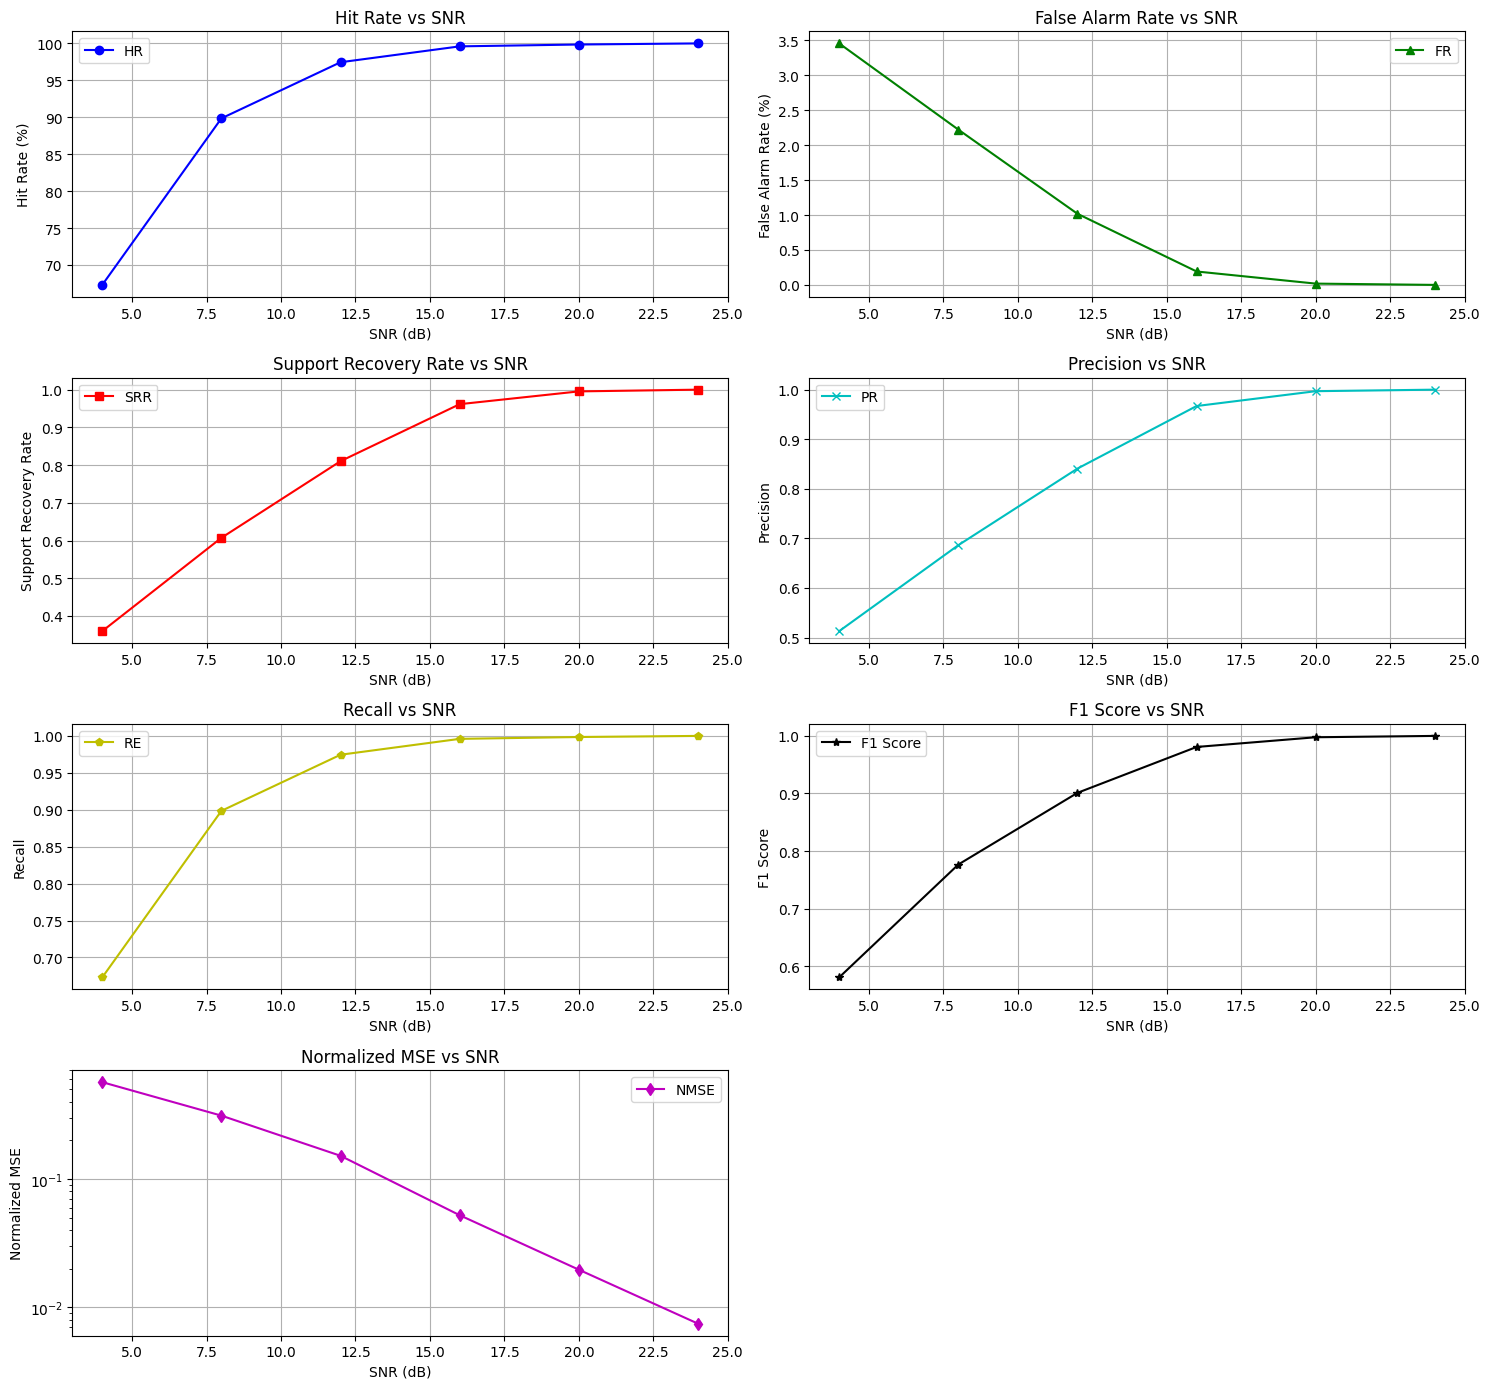

In [ ]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

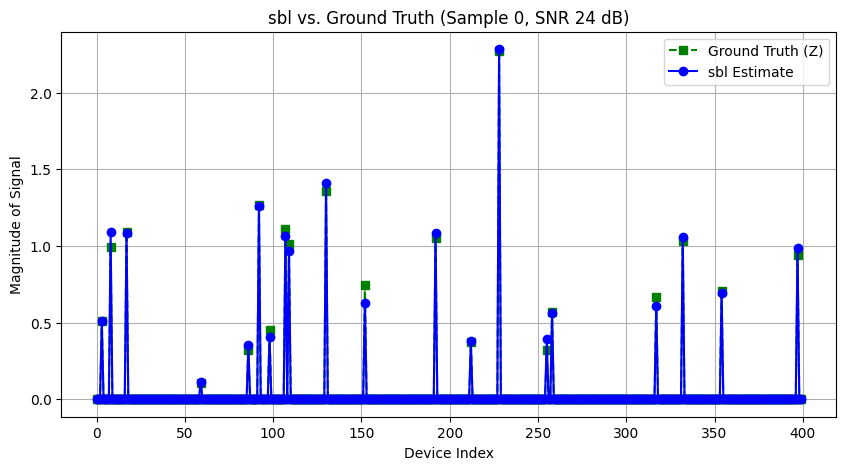

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


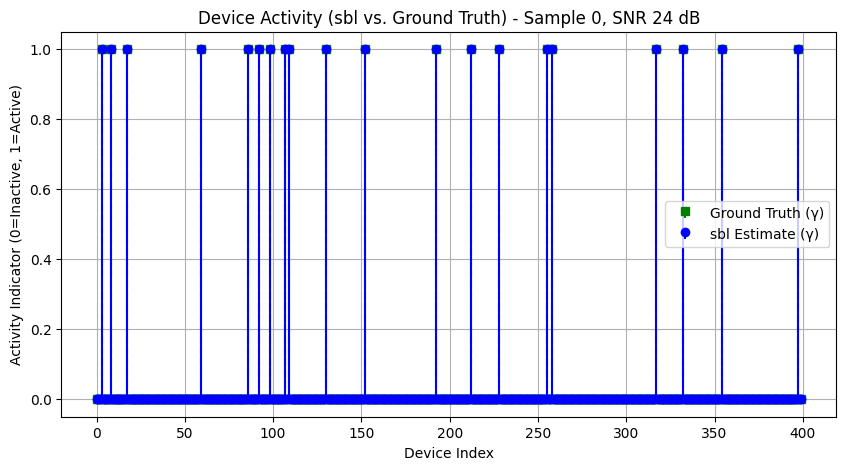

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)